In [24]:
import pandas as pd
import torch

# Load the dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

# Handle missing values (for simplicity, we'll fill them with the previous value)
df.fillna(method='ffill', inplace=True)

# Convert to PyTorch tensor
data_tensor = torch.tensor(df.values, dtype=torch.float32)


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# 1. Data Preparation

def simulate_time_series(timesteps, features):
    """Generate a random time series dataset."""
    return torch.randn(timesteps, features)

def create_delayed_data(data, window_size):
    """Segment the time series data by introducing delays."""
    return torch.stack([data[i:i+window_size] for i in range(data.shape[0] - window_size + 1)])


# 2. Neuro-Fuzzy Layer

class FuzzyLayer(nn.Module):
    def __init__(self, features, output_length, num_clusters):
        super(FuzzyLayer, self).__init__()
        self.mu = torch.nn.Parameter(data = 0.1*2*(torch.rand(num_clusters, features)-1/2), requires_grad=True)
        self.sigma_inv = nn.Parameter(torch.zeros(num_clusters, features, features), requires_grad=True)
        with torch.no_grad():
            self.sigma_inv.diagonal(dim1=-2, dim2=-1).fill_(100)
        self.lin = torch.nn.Linear(features, num_clusters*output_length)
        self.sm = torch.nn.Softmax(dim=3)

    def forward(self, y, z):
        d = torch.sub(self.mu, z.reshape(-1, y.shape[1], 1, y.shape[2]))
        dl = d.reshape(-1, y.shape[1], self.mu.shape[0], 1, y.shape[2])
        dr = d.reshape(-1, y.shape[1], self.mu.shape[0], y.shape[2], 1)
        sigma_inv = torch.matmul(self.sigma_inv, self.sigma_inv.transpose(2, 1))
        d2 = torch.clamp(torch.matmul(torch.matmul(dl, sigma_inv), dr), min=1e-12)
        psi = self.sm(-d2.reshape(-1, y.shape[1], 1, self.mu.shape[0]))
        if self.training:
            winner_mask = F.one_hot(psi.argmax(dim=3), self.mu.shape[0]).float().to(y.device)
        else:
            winner_mask = psi
        return torch.matmul(winner_mask, self.lin(y).reshape(-1, y.shape[1], self.mu.shape[0], y.shape[1]))


# 3. Model Execution

def execute_neuro_fuzzy_model(timesteps, features, window_size, num_clusters):
    # Data preparation
    time_series = simulate_time_series(timesteps, features)
    batched_time_series = create_delayed_data(time_series, window_size)
    
    # Instantiate the model and get the output
    model = FuzzyLayer(features, window_size, num_clusters)
    output = model(batched_time_series, batched_time_series)
    return output

# Run the model
fuzzy_output = execute_neuro_fuzzy_model(100, 5, 10, 5)
fuzzy_output.shape


torch.Size([91, 10, 1, 10])

In [11]:

# Plot the training signals and model predictions
def plot_training_and_predictions(training_data, predicted_data, feature_idx=0):
    """
    Plots the original training signal and the model's predictions for a specified feature.

    Parameters:
    - training_data: Tensor containing the original training data
    - predicted_data: Tensor containing the model's predicted data
    - feature_idx: Index of the feature to plot (default is 0)
    """

    # Check if tensors need to be detached and converted to numpy
    if torch.is_tensor(training_data):
        training_data = training_data.detach().cpu().numpy()
    if torch.is_tensor(predicted_data):
        predicted_data = predicted_data.detach().cpu().numpy()

    plt.figure(figsize=(14, 6))

    # Plot original training signal
    plt.plot(training_data[:, 0, feature_idx], label='Training Data', color='blue')

    # Plot model predictions
    plt.plot(predicted_data[:, 0, feature_idx], label='Model Predictions', color='red', linestyle='--')

    plt.title(f"Training Data vs Model Predictions for Feature {feature_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()



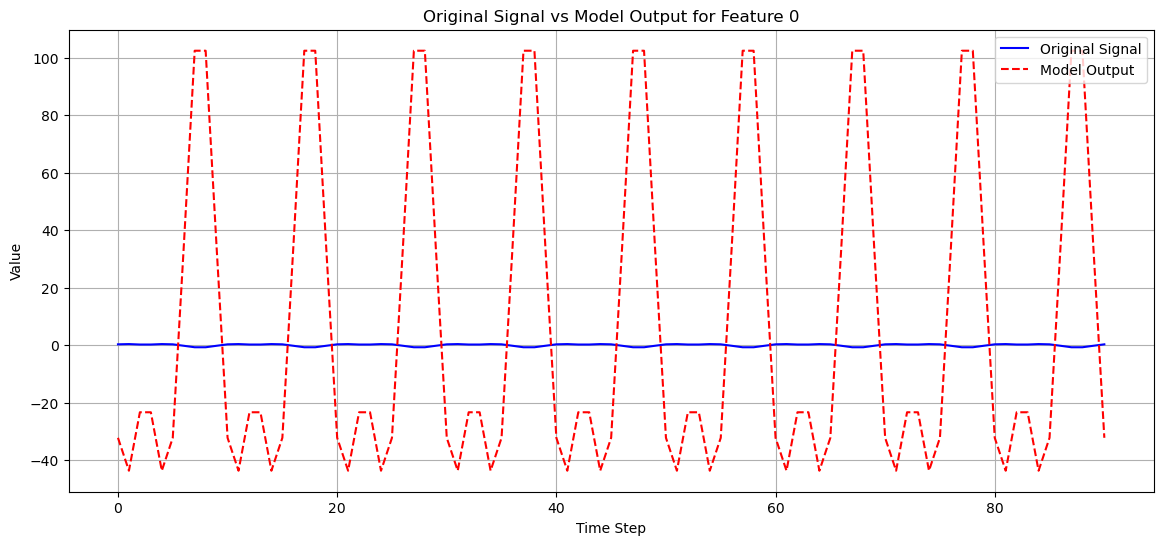

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# Create a synthetic multivariate time series dataset
def create_synthetic_multivariate_time_series(timesteps, num_features, frequency=0.1):
    time = np.arange(0, timesteps)
    # Create a time series with a combination of sine and cosine functions for each feature
    time_series = np.zeros((timesteps, num_features), dtype=np.float32)
    for i in range(num_features):
        time_series[:, i] = 0.5 * np.sin(2 * np.pi * frequency * time) + 0.3 * np.cos(4 * np.pi * frequency * time)
    return torch.tensor(time_series, dtype=torch.float32)


def create_delayed_data(data, window_size):
    """Segment the time series data by introducing delays."""
    return torch.stack([data[i:i+window_size] for i in range(data.shape[0] - window_size + 1)])

# Example usage
timesteps = 100
num_features = 5 # Number of features (you can change this as needed)
synthetic_time_series = create_synthetic_multivariate_time_series(timesteps, num_features, frequency=0.1)
batched_time_series = create_delayed_data(synthetic_time_series, 10)


class FuzzyAttentionLayer(nn.Module):
    def __init__(self, input_features, output_features, num_clusters, num_fuzzy_layers):
        super(FuzzyAttentionLayer, self).__init__()
        
        # Fuzzy Layer parameters
        self.mu = torch.nn.Parameter(data=1 * (torch.rand(num_clusters, input_features) - 1/2), requires_grad=True)
        self.sigma_inv = nn.Parameter(torch.zeros(num_clusters, input_features, input_features), requires_grad=True)
        with torch.no_grad():
            self.sigma_inv.diagonal(dim1=-2, dim2=-1).fill_(1)
        
        self.lin_fuzzy = torch.nn.Linear(input_features, num_clusters * input_features)
        self.sm = torch.nn.Softmax(dim=2)
        
        # Fuzzy layers list
        self.fuzzy_layers = nn.ModuleList([self.lin_fuzzy for _ in range(num_fuzzy_layers)])
        
        # Linear layer to transform features at the end
        self.lin_end = torch.nn.Linear(input_features, output_features)

    def compute_psi(self, z):
        d = torch.sub(self.mu, z.reshape(-1, z.shape[1], 1, self.mu.shape[1]))
        dl = d.reshape(-1, z.shape[1], self.mu.shape[0], 1, self.mu.shape[1])
        dr = d.reshape(-1, z.shape[1], self.mu.shape[0], self.mu.shape[1], 1)
        
        sigma_inv = torch.matmul(self.sigma_inv, self.sigma_inv.transpose(2, 1))
        d2 = torch.clamp(torch.matmul(torch.matmul(dl, sigma_inv), dr), min=1e-12).squeeze(-1).squeeze(-1)
        
        psi = self.sm(-d2)
        return psi

    def forward(self, x):
        for fuzzy_layer in self.fuzzy_layers:
            psi = self.compute_psi(x)
            x  =  torch.einsum('blk,blcf->blf', psi, fuzzy_layer(x).view(x.shape[0], x.shape[1], psi.shape[2], -1)) + x

        
        # Transform the features with the final linear layer
        x = self.lin_end(x)
        return x
    
class NeuroFuzzyNetwork(nn.Module):
    def __init__(self, input_dim, num_clusters_list, num_fuzzy_layers_list, output_dim):
        super(NeuroFuzzyNetwork, self).__init__()

        # Input embedding layer
        self.embedding = nn.Linear(input_dim, input_dim)

        # List of Fuzzy Attention Layers
        self.fuzzy_layers = nn.ModuleList()
        for i in range(len(num_clusters_list)):
            input_features = output_features = input_dim  # Set both input and output features to output_dim
            num_clusters = num_clusters_list[i]
            num_fuzzy_layers = num_fuzzy_layers_list[i]

            # Create FuzzyAttentionLayer instances with correct arguments
            fuzzy_layer = FuzzyAttentionLayer(input_features, output_features, num_clusters, num_fuzzy_layers)
            self.fuzzy_layers.append(fuzzy_layer)



    def forward(self, x):
        # Apply input embedding
        x = self.embedding(x)

        # Apply Fuzzy Attention Layers sequentially
        for fuzzy_layer in self.fuzzy_layers:
            x = fuzzy_layer(x)

        return x


# Define the configuration for the NeuroFuzzyNetwork
input_dim = 5
num_clusters_list = [32, 16, 8]  # Number of clusters for each Fuzzy Attention Layer
num_fuzzy_layers_list = [3, 3, 3]  # Number of fuzzy layers for each Fuzzy Attention Layer
output_dim = 3

# Create an instance of NeuroFuzzyNetwork
neuro_fuzzy_model = NeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, output_dim)

# Pass batched_time_series through the model
output = neuro_fuzzy_model(batched_time_series)
output.shape

import matplotlib.pyplot as plt

def plot_original_vs_output(original, output, feature_idx=0):
    """
    Plots the original signal vs. the output from the model for a specified feature.
    
    Parameters:
    - original: Tensor containing the original data
    - output: Tensor containing the model's output
    - feature_idx: Index of the feature to plot (default is 0)
    """
    
    # Check if tensors need to be detached and converted to numpy
    if torch.is_tensor(original):
        original = original.detach().cpu().numpy()
    if torch.is_tensor(output):
        output = output.detach().cpu().numpy()
    
    plt.figure(figsize=(14, 6))
    
    # Plot original signal
    plt.plot(original[:, 0, feature_idx], label='Original Signal', color='blue')
    
    # Plot model output
    plt.plot(output[:, 0, feature_idx], label='Model Output', color='red', linestyle='--')
    
    plt.title(f"Original Signal vs Model Output for Feature {feature_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the plotting function
plot_original_vs_output(batched_time_series, output)


In [2]:
# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(neuro_fuzzy_model.parameters(), lr=0.001)

# Training settings
epochs = 1000
train_loss_history = []

# Training loop
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    predictions = neuro_fuzzy_model(batched_time_series)
    
    # Calculate loss
    loss = loss_function(predictions, batched_time_series)
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    # Record the loss
    train_loss_history.append(loss.item())
    
    # Print the loss every 20 epochs
    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)
plt.show()

# Get the model's output after training
trained_output = neuro_fuzzy_model(batched_time_series)

# Plot the original signal vs. the trained model's output
plot_original_vs_output(batched_time_series, trained_output)


Epoch [20/1000], Loss: 71.7576
Epoch [40/1000], Loss: 16.8331
Epoch [60/1000], Loss: 3.4607


KeyboardInterrupt: 

In [3]:
# Extend the synthetic dataset
extended_timesteps = 2000  # New number of timesteps
extended_synthetic_time_series = create_synthetic_multivariate_time_series(extended_timesteps, num_features, frequency=0.1)

# Prepare training data for forecasting 30 steps into the future
def create_forecasting_data(data, input_window_size, forecast_steps):
    """Segment the time series data for forecasting."""
    X = torch.stack([data[i:i+input_window_size] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    y = torch.stack([data[i+input_window_size:i+input_window_size+forecast_steps] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    return X, y

input_window_size = 70
forecast_steps = 30

X_train, y_train = create_forecasting_data(extended_synthetic_time_series, input_window_size, forecast_steps)

X_train.shape, y_train.shape


(torch.Size([1901, 70, 5]), torch.Size([1901, 30, 5]))

Epoch [1/10], Loss: 0.2360
Epoch [2/10], Loss: 0.2186
Epoch [3/10], Loss: 0.2082
Epoch [4/10], Loss: 0.2013
Epoch [5/10], Loss: 0.1889
Epoch [6/10], Loss: 0.1840
Epoch [7/10], Loss: 0.1784
Epoch [8/10], Loss: 0.1788
Epoch [9/10], Loss: 0.1739
Epoch [10/10], Loss: 0.1722


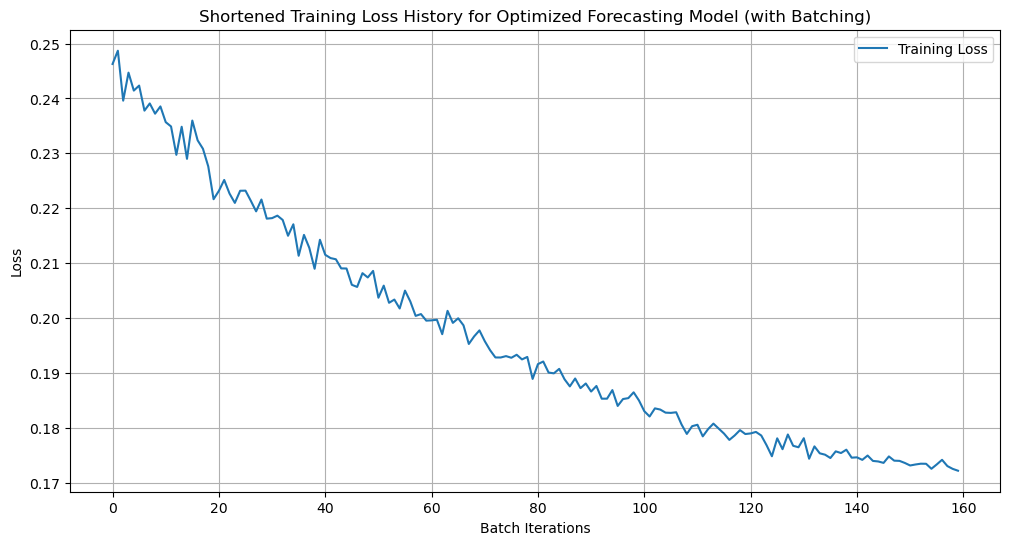

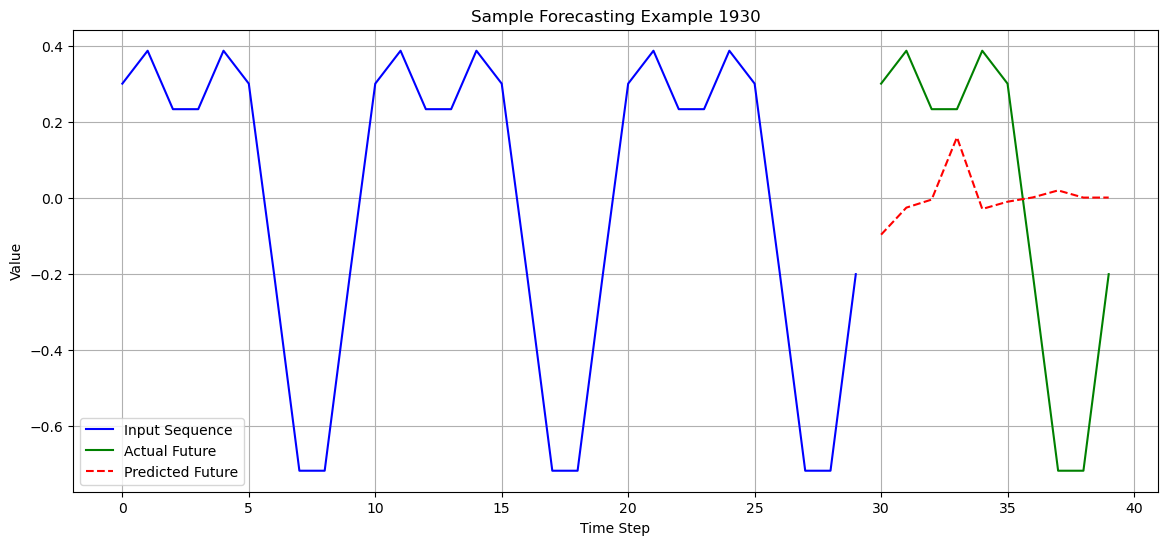

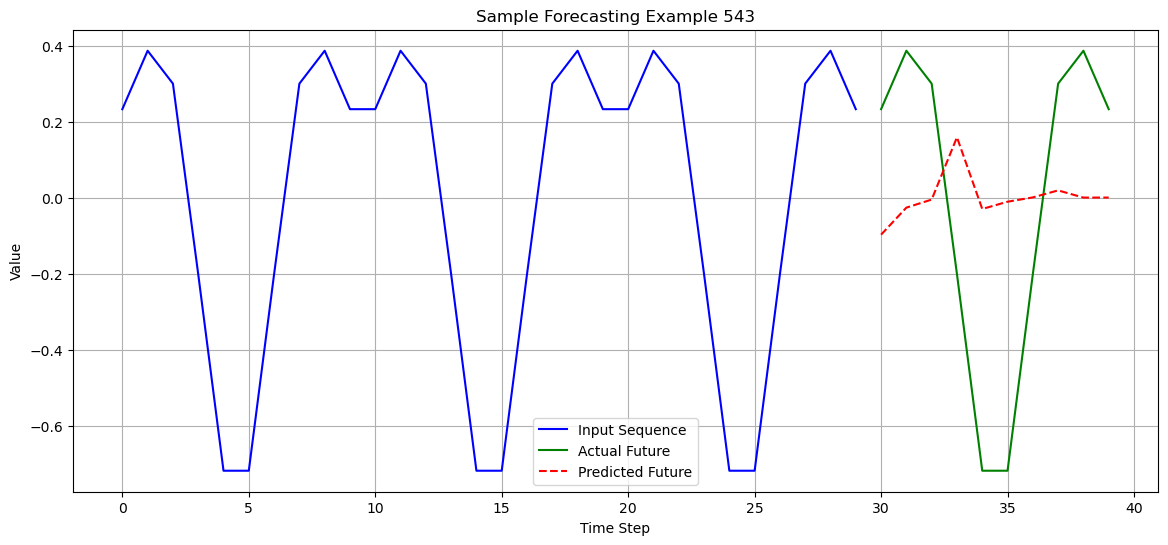

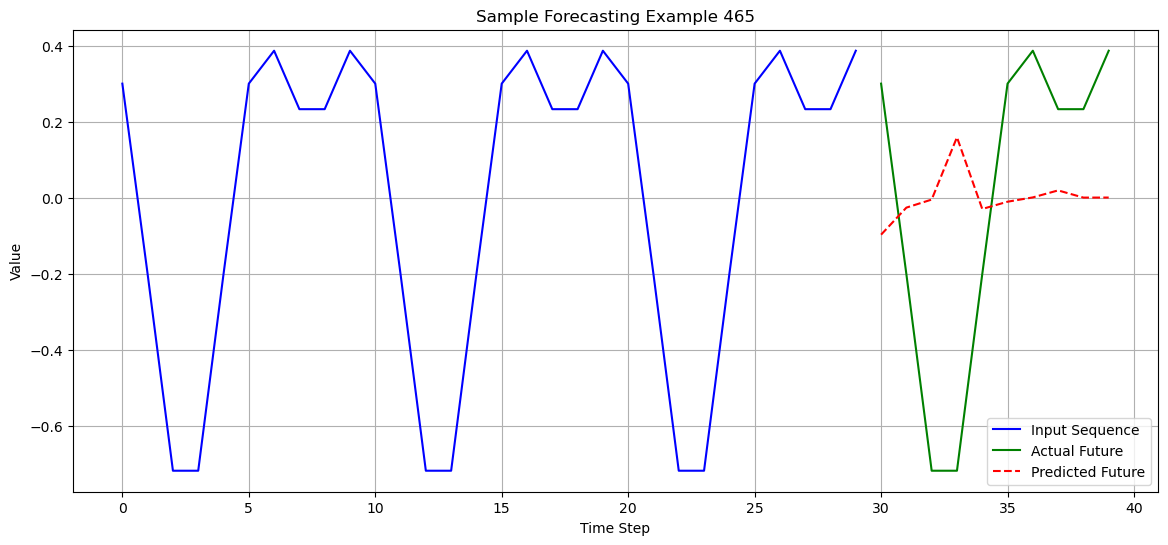

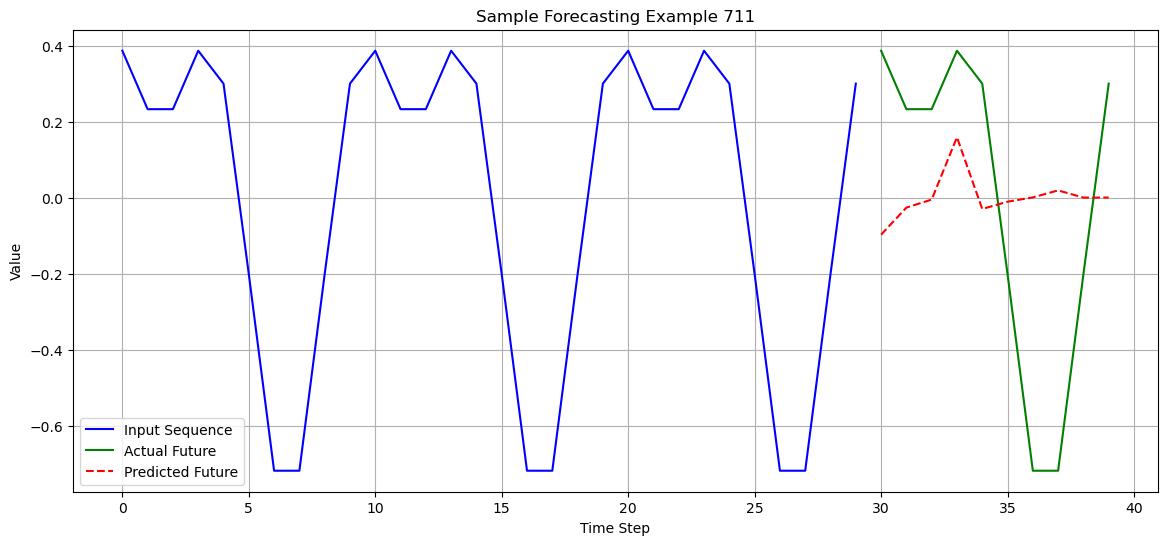

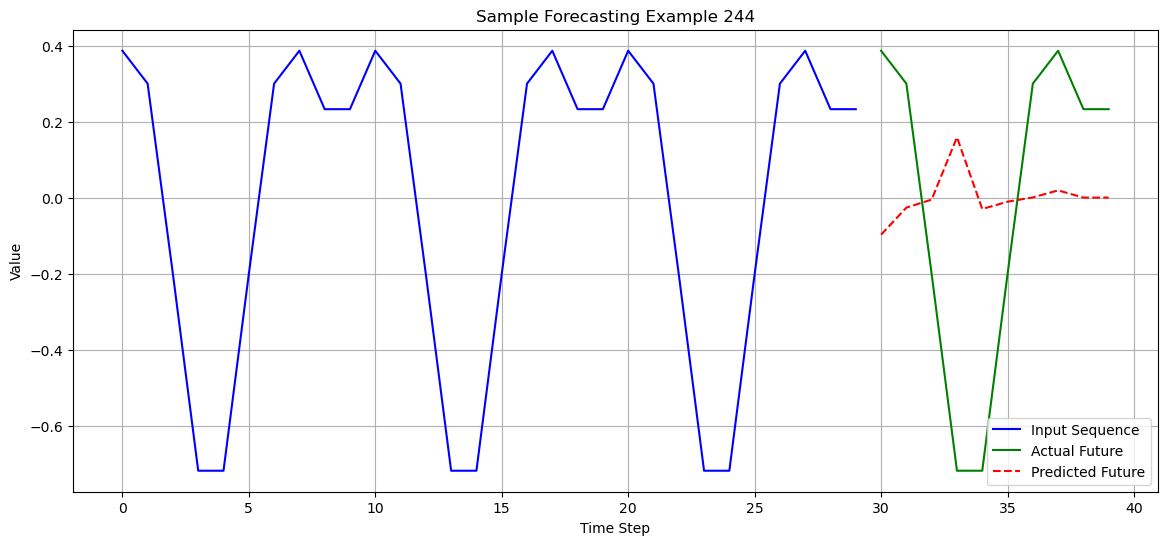

In [48]:
class MultiParameterFuzzyAttentionLayer(nn.Module):
    def __init__(self, input_features, output_features, num_clusters, num_fuzzy_layers):
        super(MultiParameterFuzzyAttentionLayer, self).__init__()
        
        # Fuzzy Layer parameters
        self.mus = nn.ParameterList([torch.nn.Parameter(data=1 * (torch.rand(num_clusters, input_features) - 1/2), requires_grad=True) for _ in range(num_fuzzy_layers)])
        self.sigma_invs = nn.ParameterList([nn.Parameter(torch.zeros(num_clusters, input_features, input_features), requires_grad=True) for _ in range(num_fuzzy_layers)])
        
        for sigma_inv in self.sigma_invs:
            with torch.no_grad():
                sigma_inv.diagonal(dim1=-2, dim2=-1).fill_(1)
        
        self.lin_fuzzies = nn.ModuleList([torch.nn.Linear(input_features, num_clusters * input_features) for _ in range(num_fuzzy_layers)])
        self.sm = torch.nn.Softmax(dim=2)
        
        # Linear layer to transform features at the end
        self.lin_end = torch.nn.Linear(input_features, output_features)

        # Feed-forward layers list
        self.ffn_layers = nn.ModuleList([nn.Sequential(
                nn.Linear(input_features, input_features),
                nn.ReLU(),
                nn.Linear(input_features, input_features)
            ) for _ in range(num_fuzzy_layers)])

    def compute_psi(self, z, mu, sigma_inv):
        # Adjusting the tensor dimensions for computation
        d = torch.sub(mu.unsqueeze(0).unsqueeze(0), z.unsqueeze(2))
        d_expanded = d.unsqueeze(-2)
        sigma_inv_expanded = sigma_inv.unsqueeze(0).unsqueeze(1)
        
        d2_part = d_expanded @ sigma_inv_expanded @ d.unsqueeze(-1)
        d2 = d2_part.squeeze(-1).squeeze(-1)
        
        psi = self.sm(-d2)
        return psi

    def forward(self, x):
        for i in range(len(self.lin_fuzzies)):
            psi = self.compute_psi(x, self.mus[i], self.sigma_invs[i])
            x = torch.einsum('blk,blcf->blf', psi, self.lin_fuzzies[i](x).view(x.shape[0], x.shape[1], psi.shape[2], -1)) + x
            x = self.ffn_layers[i](x) + x  # Add the output of the FFN to the original 'x' (Residual connection)
        
        # Transform the features with the final linear layer
        x = self.lin_end(x)
        return x

# Test the MultiParameterFuzzyAttentionLayer with a small batch
test_input = X_train[:10]
test_output = MultiParameterFuzzyAttentionLayer(input_dim, input_dim, num_clusters_list[0], num_fuzzy_layers_list[0])(test_input)
test_output.shape

class TemporalFuzzyAttentionLayer(nn.Module):
    def __init__(self, input_features, output_features, num_clusters, num_fuzzy_layers):
        super(TemporalFuzzyAttentionLayer, self).__init__()
        
        # Fuzzy Layer parameters
        self.mus = nn.ParameterList([torch.nn.Parameter(data=1 * (torch.rand(num_clusters, input_features) - 1/2), requires_grad=True) for _ in range(num_fuzzy_layers)])
        self.sigma_invs = nn.ParameterList([nn.Parameter(torch.zeros(num_clusters, input_features, input_features), requires_grad=True) for _ in range(num_fuzzy_layers)])
        
        for sigma_inv in self.sigma_invs:
            with torch.no_grad():
                sigma_inv.diagonal(dim1=-2, dim2=-1).fill_(1)
        
        self.lin_fuzzies = nn.ModuleList([torch.nn.Linear(input_features, num_clusters * input_features) for _ in range(num_fuzzy_layers)])
        self.sm = torch.nn.Softmax(dim=1)  # Adjusted the softmax dimension to work across the sequence length
        
        # Feed-forward layers list with ffn_hidden_dim set to input_features
        self.ffn_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(input_features, input_features),
            nn.ReLU(),
            nn.Linear(input_features, input_features)
        ) for _ in range(num_fuzzy_layers)])
        
        # Linear layer to transform features at the end
        self.lin_end = torch.nn.Linear(input_features, output_features)

    def compute_psi(self, z, mu, sigma_inv):
        # Adjusting the tensor dimensions for computation
        d = torch.sub(mu.unsqueeze(0).unsqueeze(0), z.unsqueeze(2))
        d_expanded = d.unsqueeze(-2)
        sigma_inv_expanded = sigma_inv.unsqueeze(0).unsqueeze(1)
        
        d2_part = d_expanded @ sigma_inv_expanded @ d.unsqueeze(-1)
        d2 = d2_part.squeeze(-1).squeeze(-1)
        
        psi = self.sm(-d2)
        return psi

    def forward(self, x):
        for i in range(len(self.lin_fuzzies)):
            psi = self.compute_psi(x, self.mus[i], self.sigma_invs[i])
            # Adjusted the attention computation to work across the sequence length
            x_transformed = self.lin_fuzzies[i](x).view(x.shape[0], x.shape[1], psi.shape[2], -1)
            x_weighted = torch.einsum('btl,btlf->blf', psi, x_transformed)
            x = x_weighted + self.ffn_layers[i](x_weighted)  # Apply FFN on the weighted sum
        
        # Transform the features with the final linear layer
        x = self.lin_end(x)
        return x

# Test the CorrectedTemporalFuzzyAttentionLayer with a small batch
test_output_temporal_corrected = TemporalFuzzyAttentionLayer(input_dim, input_dim, num_clusters_list[0], num_fuzzy_layers_list[0])(test_input)
test_output_temporal_corrected.shape


class ForecastingNeuroFuzzyNetwork(nn.Module):
    def __init__(self, input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, num_features):
        super(ForecastingNeuroFuzzyNetwork, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        self.fuzzy_layers = nn.ModuleList()
        for i in range(len(num_clusters_list)):
            input_features = output_features = input_dim  
            num_clusters = num_clusters_list[i]
            num_fuzzy_layers = num_fuzzy_layers_list[i]
            fuzzy_layer = FuzzyAttentionLayer(input_features, output_features, num_clusters, num_fuzzy_layers)
            self.fuzzy_layers.append(fuzzy_layer)

        # Adjusting the final layer to output forecast_steps * num_features
        self.final_layer = nn.Linear(input_dim, forecast_steps * num_features)

    def forward(self, x):
        x = self.embedding(x)
        for fuzzy_layer in self.fuzzy_layers:
            x = fuzzy_layer(x)
        x = self.final_layer(x[:, -1, :])  # Use the last timestep of input to predict future steps
        return x.view(x.size(0), forecast_steps, -1)  # Reshape the output to [batch_size, forecast_steps, num_features]

# Adjusting the FuzzyAttentionLayer to be the CorrectedTemporalFuzzyAttentionLayer
# and integrating it into the ForecastingNeuroFuzzyNetwork

class ForecastingNeuroFuzzyNetwork(nn.Module):
    def __init__(self, input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, num_features):
        super(ForecastingNeuroFuzzyNetwork, self).__init__()
        
        self.embedding = nn.Linear(input_dim, input_dim)
        
        self.fuzzy_layers = nn.ModuleList()
        for i in range(len(num_clusters_list)):
            input_features = output_features = input_dim  
            num_clusters = num_clusters_list[i]
            num_fuzzy_layers = num_fuzzy_layers_list[i]
            
            # Use the CorrectedTemporalFuzzyAttentionLayer
            fuzzy_layer = TemporalFuzzyAttentionLayer(input_features, output_features, num_clusters, num_fuzzy_layers)
            self.fuzzy_layers.append(fuzzy_layer)

        # Adjusting the final layer to output forecast_steps * num_features
        self.final_layer = nn.Linear(input_dim, forecast_steps * num_features)

    def forward(self, x):
        x = self.embedding(x)
        for fuzzy_layer in self.fuzzy_layers:
            x = fuzzy_layer(x)
        x = self.final_layer(x[:, -1, :])  # Use the last timestep of input to predict future steps
        return x.view(x.size(0), forecast_steps, -1)  # Reshape the output to [batch_size, forecast_steps, num_features]

# Test the ForecastingNeuroFuzzyNetwork with a small batch
forecasting_model = ForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, input_dim)
test_forecasting_output = forecasting_model(test_input)
test_forecasting_output.shape


# Redefining the FuzzyAttentionLayer for feature attention

class FuzzyAttentionLayer(nn.Module):
    def __init__(self, input_features, output_features, num_clusters, num_fuzzy_layers):
        super(FuzzyAttentionLayer, self).__init__()
        
        # Fuzzy Layer parameters
        self.mus = nn.ParameterList([torch.nn.Parameter(data=1 * (torch.rand(num_clusters, input_features) - 1/2), requires_grad=True) for _ in range(num_fuzzy_layers)])
        self.sigma_invs = nn.ParameterList([nn.Parameter(torch.zeros(num_clusters, input_features, input_features), requires_grad=True) for _ in range(num_fuzzy_layers)])
        
        for sigma_inv in self.sigma_invs:
            with torch.no_grad():
                sigma_inv.diagonal(dim1=-2, dim2=-1).fill_(1)
        
        self.lin_fuzzies = nn.ModuleList([torch.nn.Linear(input_features, num_clusters * input_features) for _ in range(num_fuzzy_layers)])
        self.sm = torch.nn.Softmax(dim=2)
        
        
        # Linear layer to transform features at the end
        self.lin_end = torch.nn.Linear(input_features, output_features)

    def compute_psi(self, z, mu, sigma_inv):
        # Adjusting the tensor dimensions for computation
        d = torch.sub(mu.unsqueeze(0).unsqueeze(0), z.unsqueeze(2))
        d_expanded = d.unsqueeze(-2)
        sigma_inv_expanded = sigma_inv.unsqueeze(0).unsqueeze(1)
        
        d2_part = d_expanded @ sigma_inv_expanded @ d.unsqueeze(-1)
        d2 = d2_part.squeeze(-1).squeeze(-1)
        
        psi = self.sm(-d2)
        return psi

    def forward(self, x):
        for i in range(len(self.lin_fuzzies)):
            psi = self.compute_psi(x, self.mus[i], self.sigma_invs[i])
            x_transformed = self.lin_fuzzies[i](x).view(x.shape[0], x.shape[1], psi.shape[2], -1)
            x = torch.einsum('btl,btlf->blf', psi, x_transformed)
        
        # Transform the features with the final linear layer
        x = self.lin_end(x)
        return x

class CombinedForecastingNeuroFuzzyNetwork(nn.Module):
    def __init__(self, input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, num_features):
        super(CombinedForecastingNeuroFuzzyNetwork, self).__init__()
        
        self.embedding = nn.Linear(input_dim, input_dim)
        
        # Temporal Fuzzy Attention Layers
        self.temporal_fuzzy_layers = nn.ModuleList()
        # Feature Fuzzy Attention Layers
        self.feature_fuzzy_layers = nn.ModuleList()
        
        for i in range(len(num_clusters_list)):
            input_features = output_features = input_dim  
            num_clusters = num_clusters_list[i]
            num_fuzzy_layers = num_fuzzy_layers_list[i]
            
            # Temporal Attention Layer
            temporal_fuzzy_layer = TemporalFuzzyAttentionLayer(input_features, output_features, num_clusters, num_fuzzy_layers)
            self.temporal_fuzzy_layers.append(temporal_fuzzy_layer)
            
            # Feature Attention Layer
            feature_fuzzy_layer = FuzzyAttentionLayer(input_features, output_features, num_clusters, num_fuzzy_layers)
            self.feature_fuzzy_layers.append(feature_fuzzy_layer)

        # Adjusting the final layer to output forecast_steps * num_features
        self.final_layer = nn.Linear(input_dim, forecast_steps * num_features)

    def forward(self, x):
        x = self.embedding(x)
        
        # Sequentially pass through the Temporal and then Feature Attention Layers
        for temporal_fuzzy_layer, feature_fuzzy_layer in zip(self.temporal_fuzzy_layers, self.feature_fuzzy_layers):
            x = temporal_fuzzy_layer(x)
            x = feature_fuzzy_layer(x)
        
        x = self.final_layer(x[:, -1, :])  # Use the last timestep of input to predict future steps
        return x.view(x.size(0), forecast_steps, -1)  # Reshape the output to [batch_size, forecast_steps, num_features]



forecast_steps = 10
input_window_size = 30
num_features = 5
input_dim = 5
num_clusters_list = [8, 4, 1]
num_fuzzy_layers_list = [2, 1, 0]

# Test the CombinedForecastingNeuroFuzzyNetwork with a small batch again
combined_forecasting_model = CombinedForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, input_dim)
test_combined_forecasting_output = combined_forecasting_model(test_input)
test_combined_forecasting_output.shape


# Create an instance of the optimized forecasting NeuroFuzzyNetwork
#optimized_forecasting_model = ForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, num_features)

# Define the optimizer for the optimized forecasting model
optimizer_optimized_forecasting = torch.optim.Adam(combined_forecasting_model.parameters(), lr=0.001)

# Training loop with batching for the optimized forecasting model
shortened_epochs = 10
optimized_forecasting_train_loss_history = []

def create_forecasting_data(data, input_window_size, forecast_steps):
    """Segment the time series data for forecasting."""
    X = torch.stack([data[i:i+input_window_size] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    y = torch.stack([data[i+input_window_size:i+input_window_size+forecast_steps] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    return X, y

extended_timesteps = 2000
extended_synthetic_time_series = create_synthetic_multivariate_time_series(extended_timesteps, num_features, frequency=0.1)
X_train, y_train = create_forecasting_data(extended_synthetic_time_series, input_window_size, forecast_steps)

batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(shortened_epochs):
    for batch_X, batch_y in train_loader:
        # Zero the gradients
        optimizer_optimized_forecasting.zero_grad()

        # Forward pass
        predictions = combined_forecasting_model(batch_X)

        # Calculate loss
        loss = loss_function(predictions, batch_y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer_optimized_forecasting.step()

        # Record the loss
        optimized_forecasting_train_loss_history.append(loss.item())


    print(f"Epoch [{epoch+1}/{shortened_epochs}], Loss: {loss.item():.4f}")

# Plot the training loss for optimized forecasting model (shortened training)
plt.figure(figsize=(12, 6))
plt.plot(optimized_forecasting_train_loss_history, label="Training Loss")
plt.xlabel("Batch Iterations")
plt.ylabel("Loss")
plt.title("Shortened Training Loss History for Optimized Forecasting Model (with Batching)")
plt.legend()
plt.grid(True)
plt.show()

# Visualization of model's predictions
sample_idx = np.random.choice(len(X_train), 5, replace=False)
for idx in sample_idx:
    sample_input = X_train[idx].unsqueeze(0)
    actual_output = y_train[idx]
    predicted_output = combined_forecasting_model(sample_input)
    
    plt.figure(figsize=(14, 6))
    plt.plot(range(input_window_size), sample_input[0, :, 0].detach().cpu(), label="Input Sequence", color="blue")
    plt.plot(range(input_window_size, input_window_size + forecast_steps), actual_output[:, 0].detach().cpu(), label="Actual Future", color="green")
    plt.plot(range(input_window_size, input_window_size + forecast_steps), predicted_output[0, :, 0].detach().cpu(), label="Predicted Future", color="red", linestyle="--")
    plt.title(f"Sample Forecasting Example {idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


In [49]:
class MultiHeadFuzzyAttentionLayer(nn.Module):
    def __init__(self, input_features, output_features, num_clusters, num_fuzzy_layers, num_heads):
        super(MultiHeadFuzzyAttentionLayer, self).__init__()
        
        self.num_heads = num_heads
        head_dim = input_features // num_heads
        
        # Ensure the division is exact
        assert head_dim * num_heads == input_features, "input_features must be divisible by num_heads"
        
        # Layers for splitting into heads and combining them back
        self.split_heads = nn.Linear(input_features, input_features)
        self.combine_heads = nn.Linear(input_features, output_features)
        
        # Multiple Fuzzy Attention Layers for each head
        self.fuzzy_attention_heads = nn.ModuleList([
            FuzzyAttentionLayer(head_dim, head_dim, num_clusters, num_fuzzy_layers)
            for _ in range(num_heads)
        ])
    
    def forward(self, x):

        batch_size, seq_length, _ = x.shape
        
        # Split the last dimension into (num_heads, depth)
        x = self.split_heads(x).view(batch_size, seq_length, self.num_heads, -1)
        
        # Apply each Fuzzy Attention head
        heads_outputs = [fuzzy_head(x[:, :, i]) for i, fuzzy_head in enumerate(self.fuzzy_attention_heads)]
        
        # Concatenate the outputs of all heads together
        concat_heads = torch.cat(heads_outputs, dim=2)
        
        # Combine heads
        combined_output = self.combine_heads(concat_heads)
        
        return combined_output
    
class MultiHeadForecastingNeuroFuzzyNetwork(nn.Module):
    def __init__(self, input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, num_features, num_heads):
        super(MultiHeadForecastingNeuroFuzzyNetwork, self).__init__()

        self.embedding = nn.Linear(input_dim, input_dim)        
        
        # Multi-Head Fuzzy Attention Layers
        self.multihead_fuzzy_layers = nn.ModuleList()
        
        for i in range(len(num_clusters_list)):
            input_features = output_features = input_dim  
            num_clusters = num_clusters_list[i]
            num_fuzzy_layers = num_fuzzy_layers_list[i]
            
            # Multi-Head Fuzzy Attention Layer
            multihead_fuzzy_layer = MultiHeadFuzzyAttentionLayer(input_features, output_features, num_clusters, num_fuzzy_layers, num_heads)
            self.multihead_fuzzy_layers.append(multihead_fuzzy_layer)

        # Adjusting the final layer to output forecast_steps * num_features
        self.final_layer = nn.Linear(input_dim, forecast_steps * num_features)

    def forward(self, x):
        x = self.embedding(x)
        
        # Pass through the Multi-Head Fuzzy Attention Layers
        for multihead_fuzzy_layer in self.multihead_fuzzy_layers:
            x = multihead_fuzzy_layer(x)
        
        x = self.final_layer(x[:, -1, :])  # Use the last timestep of input to predict future steps
        return x.view(x.size(0), forecast_steps, -1)  # Reshape the output to [batch_size, forecast_steps, num_features]

# Test the MultiHeadForecastingNeuroFuzzyNetwork with a small batch
multihead_forecasting_model = MultiHeadForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, input_dim, num_heads)
test_multihead_forecasting_output = multihead_forecasting_model(test_input)
test_multihead_forecasting_output.shape

# Parameters and data setup
forecast_steps = 10
input_window_size = 30
num_features = 5
input_dim = 5
num_clusters_list = [16, 8, 1]
num_fuzzy_layers_list = [3, 1, 1]
num_heads = 5  # Number of heads for the MultiHeadFuzzyAttentionLayer

# Create forecasting data
def create_forecasting_data(data, input_window_size, forecast_steps):
    """Segment the time series data for forecasting."""
    X = torch.stack([data[i:i+input_window_size] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    y = torch.stack([data[i+input_window_size:i+input_window_size+forecast_steps] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    return X, y

extended_timesteps = 200
extended_synthetic_time_series = create_synthetic_multivariate_time_series(extended_timesteps, num_features, frequency=0.1)
X_train, y_train = create_forecasting_data(extended_synthetic_time_series, input_window_size, forecast_steps)

# DataLoader for training
batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Loss function
loss_function = nn.MSELoss()

# Model and Optimizer
multihead_forecasting_model = MultiHeadForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, input_dim, num_heads)
optimizer = torch.optim.Adam(multihead_forecasting_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = multihead_forecasting_model(batch_X)
        loss = loss_function(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

loss_history


Epoch 1/10, Loss: 0.4697
Epoch 2/10, Loss: 0.4469
Epoch 3/10, Loss: 0.4125
Epoch 4/10, Loss: 0.3951
Epoch 5/10, Loss: 0.3695
Epoch 6/10, Loss: 0.3580
Epoch 7/10, Loss: 0.3454
Epoch 8/10, Loss: 0.3273
Epoch 9/10, Loss: 0.3105
Epoch 10/10, Loss: 0.3007


[0.46966585516929626,
 0.44693057239055634,
 0.4125148802995682,
 0.3950534909963608,
 0.36948028206825256,
 0.3579864948987961,
 0.34544211626052856,
 0.32728107273578644,
 0.3104935735464096,
 0.30065760016441345]

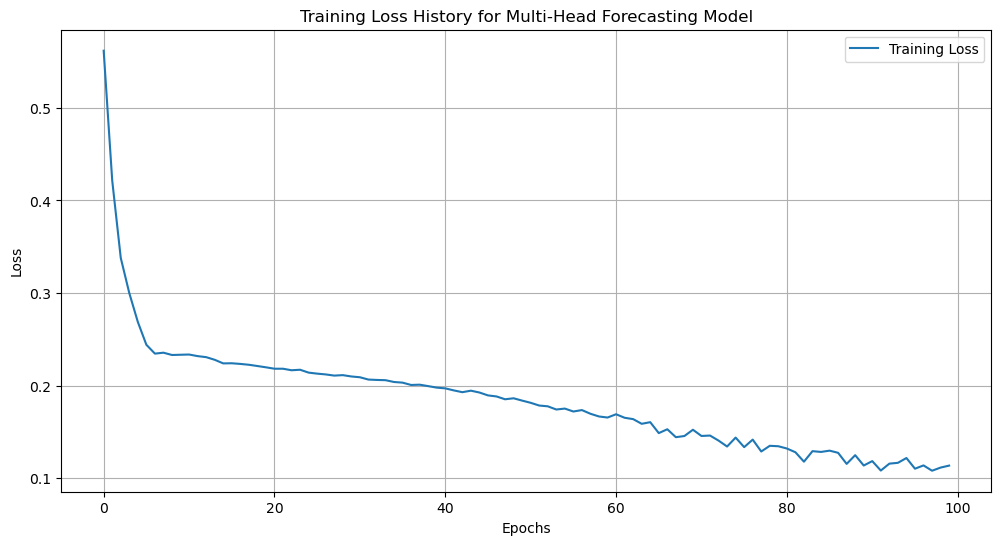

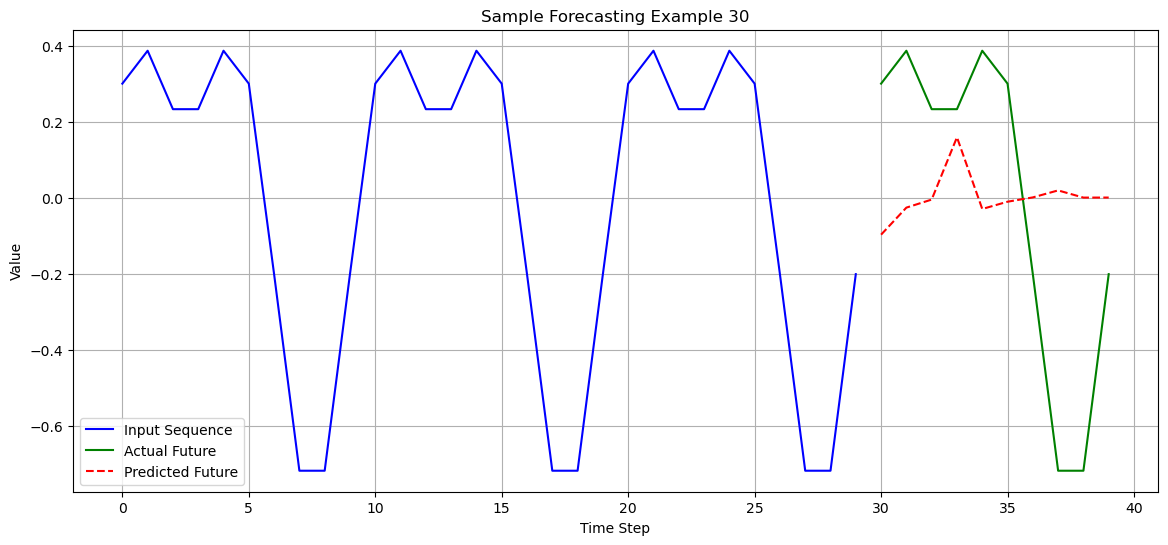

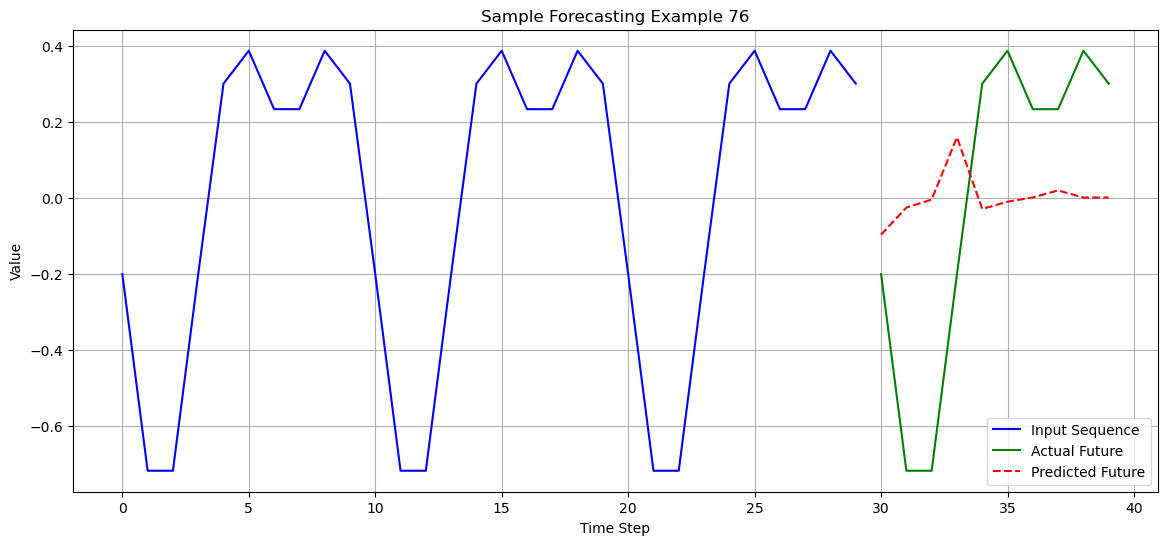

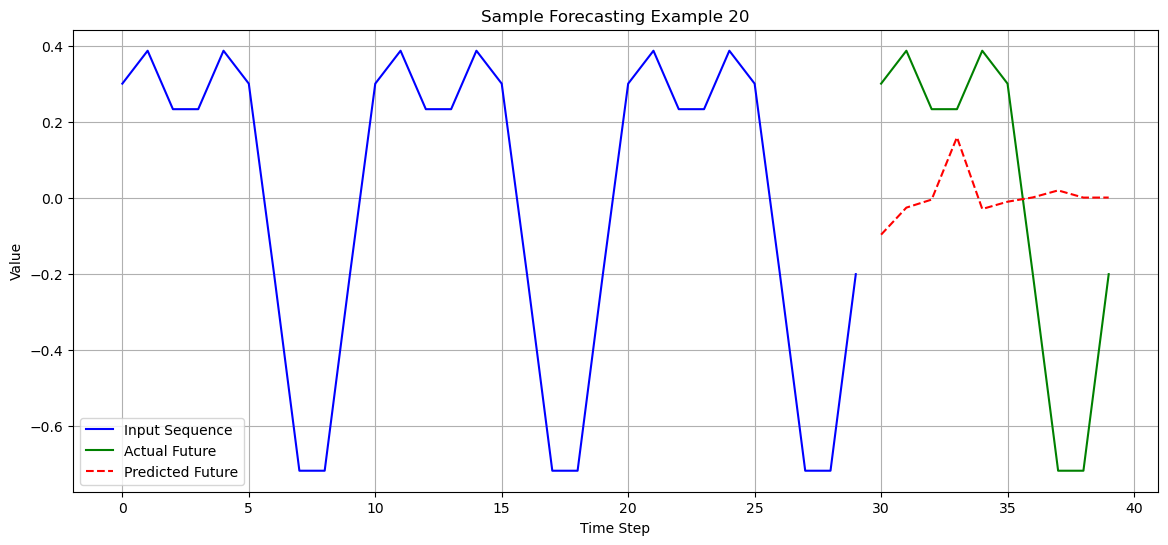

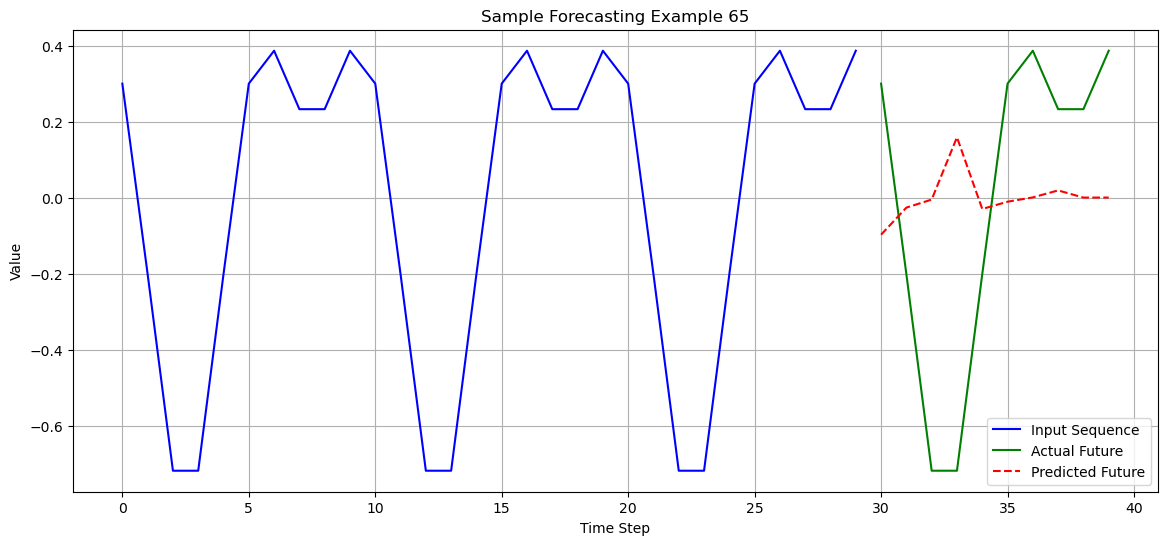

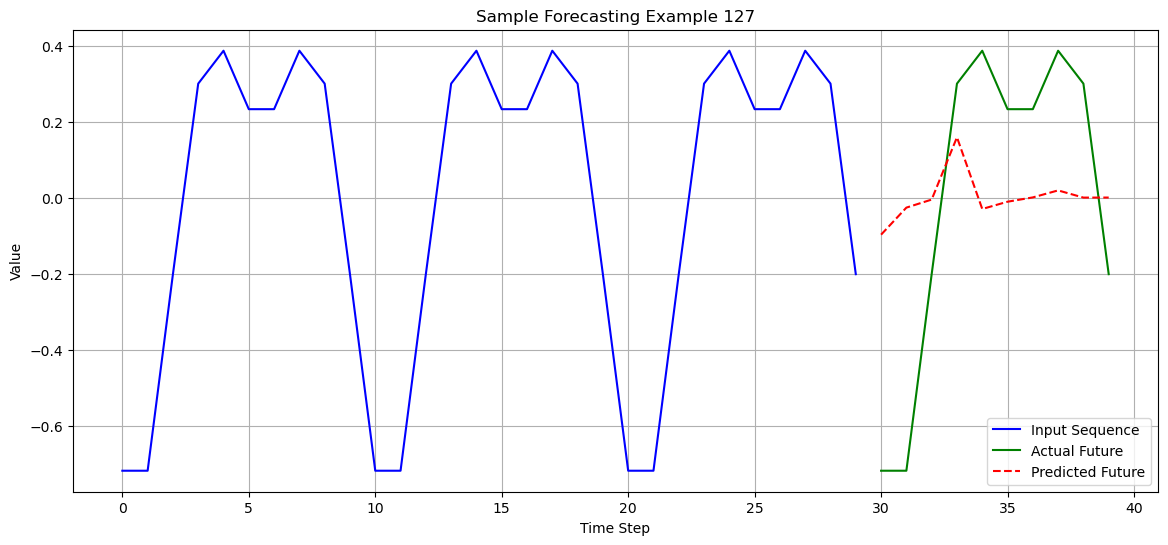

In [63]:
import matplotlib.pyplot as plt

# Plot the training loss for the multi-head forecasting model
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss History for Multi-Head Forecasting Model")
plt.legend()
plt.grid(True)
plt.show()

# Visualization of model's predictions
sample_idx = np.random.choice(len(X_train), 5, replace=False)
for idx in sample_idx:
    sample_input = X_train[idx].unsqueeze(0)
    actual_output = y_train[idx]
    predicted_output = multihead_forecasting_model(sample_input)
    
    plt.figure(figsize=(14, 6))
    plt.plot(range(input_window_size), sample_input[0, :, 0].detach().cpu(), label="Input Sequence", color="blue")
    plt.plot(range(input_window_size, input_window_size + forecast_steps), actual_output[:, 0].detach().cpu(), label="Actual Future", color="green")
    plt.plot(range(input_window_size, input_window_size + forecast_steps), predicted_output[0, :, 0].detach().cpu(), label="Predicted Future", color="red", linestyle="--")
    plt.title(f"Sample Forecasting Example {idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MultiHeadFuzzyAttentionLayer(nn.Module):
    def __init__(self, input_features, output_features, num_clusters, num_heads, num_fuzzy_layers, input_embedding_size):
        super(MultiHeadFuzzyAttentionLayer, self).__init__()
        
        self.embedding = nn.Linear(input_features, input_embedding_size)
        assert input_embedding_size % num_heads == 0, "Input embedding size must be divisible by the number of heads"
        self.head_dim = input_embedding_size // num_heads
        self.num_heads = num_heads

        # Initialize Fuzzy Layer parameters for each head
        self._init_fuzzy_parameters(num_clusters, num_fuzzy_layers)

        self.sm = torch.nn.Softmax(dim=2)
        self.combine_heads = nn.Linear(num_heads * self.head_dim, output_features)

    def _init_fuzzy_parameters(self, num_clusters, num_fuzzy_layers):
        self.mus = nn.ModuleList([nn.ParameterList([torch.nn.Parameter(data=1 * (torch.rand(num_clusters, self.head_dim) - 1/2), requires_grad=True) for _ in range(num_fuzzy_layers)]) for _ in range(self.num_heads)])
        self.sigma_invs = nn.ModuleList([nn.ParameterList([nn.Parameter(torch.zeros(num_clusters, self.head_dim, self.head_dim), requires_grad=True) for _ in range(num_fuzzy_layers)]) for _ in range(self.num_heads)])
        
        for sigma_invs_head in self.sigma_invs:
            for sigma_inv in sigma_invs_head:
                with torch.no_grad():
                    sigma_inv.diagonal(dim1=-2, dim2=-1).fill_(1)
        
        self.lin_fuzzies = nn.ModuleList([nn.ModuleList([torch.nn.Linear(self.head_dim, num_clusters * self.head_dim) for _ in range(num_fuzzy_layers)]) for _ in range(self.num_heads)])

    def _compute_psi(self, z, mu, sigma_inv):
        d = torch.sub(mu.unsqueeze(0).unsqueeze(0), z.unsqueeze(2))
        d_expanded = d.unsqueeze(-2)
        sigma_inv_expanded = sigma_inv.unsqueeze(0).unsqueeze(1)
        d2_part = d_expanded @ sigma_inv_expanded @ d.unsqueeze(-1)
        d2 = d2_part.squeeze(-1).squeeze(-1)
        psi = self.sm(-d2)
        return psi

    def _process_head(self, x_head, idx):
        for j in range(len(self.lin_fuzzies[idx])):
            psi = self._compute_psi(x_head, self.mus[idx][j], self.sigma_invs[idx][j])
            x_transformed = self.lin_fuzzies[idx][j](x_head).view(x_head.shape[0], x_head.shape[1], psi.shape[2], -1)
            x_head = torch.einsum('btl,btlf->blf', psi, x_transformed)
        return x_head

    def forward(self, x):
        x = self.embedding(x)
        x_heads = torch.chunk(x, self.num_heads, dim=-1)
        outputs = [self._process_head(x_head, idx) for idx, x_head in enumerate(x_heads)]
        concatenated_output = torch.cat(outputs, dim=-1)
        return self.combine_heads(concatenated_output)

# Test the refactored MultiHeadFuzzyAttentionLayer
multi_head_attention_layer = MultiHeadFuzzyAttentionLayer(input_features=5, output_features=5, num_clusters=8, num_heads=8, num_fuzzy_layers=2, input_embedding_size=32)
dummy_input = torch.randn(10, 3, 5)
output = multi_head_attention_layer(dummy_input)
output.shape

torch.Size([10, 8, 5])

In [83]:

class MultiHeadForecastingNeuroFuzzyNetwork(nn.Module):
    def __init__(self, input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, output_dim, num_heads):
        super(MultiHeadForecastingNeuroFuzzyNetwork, self).__init__()
        
        assert len(num_clusters_list) == len(num_fuzzy_layers_list), "Mismatch in the length of num_clusters_list and num_fuzzy_layers_list"
        
        self.layers = nn.ModuleList()
        input_size = input_dim
        
        for num_clusters, num_fuzzy_layers in zip(num_clusters_list, num_fuzzy_layers_list):
            layer = MultiHeadFuzzyAttentionLayer(input_features=input_size, 
                                                 output_features=output_dim, 
                                                 num_clusters=num_clusters, 
                                                 num_heads=num_heads, 
                                                 num_fuzzy_layers=num_fuzzy_layers, 
                                                 input_embedding_size=input_size * num_heads)
            self.layers.append(layer)
            input_size = output_dim
        
        # Adjust the final layer to produce the correct shape
        self.final_layer = nn.Linear(input_size, forecast_steps * num_features)
        
        # Positional embeddings
        self.position_embedding = nn.Embedding(input_window_size, input_dim)
    
    def forward(self, x):
        # Generate position_ids based on the batch size
        position_ids = torch.arange(input_window_size).expand((x.size(0), -1)).to(x.device)
        
        # Add positional embeddings
        pos_emb = self.position_embedding(position_ids)
        x += pos_emb
        
        for layer in self.layers:
            x = layer(x)
        x = self.final_layer(x)
        return x.view(x.size(0), forecast_steps, num_features)

# Test the updated model
model_with_positional_embedding = MultiHeadForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, input_dim, num_heads)
model_with_positional_embedding

MultiHeadForecastingNeuroFuzzyNetwork(
  (layers): ModuleList(
    (0): MultiHeadFuzzyAttentionLayer(
      (embedding): Linear(in_features=5, out_features=25, bias=True)
      (mus): ModuleList(
        (0): ParameterList(
            (0): Parameter containing: [torch.float32 of size 16x5]
            (1): Parameter containing: [torch.float32 of size 16x5]
            (2): Parameter containing: [torch.float32 of size 16x5]
        )
        (1): ParameterList(
            (0): Parameter containing: [torch.float32 of size 16x5]
            (1): Parameter containing: [torch.float32 of size 16x5]
            (2): Parameter containing: [torch.float32 of size 16x5]
        )
        (2): ParameterList(
            (0): Parameter containing: [torch.float32 of size 16x5]
            (1): Parameter containing: [torch.float32 of size 16x5]
            (2): Parameter containing: [torch.float32 of size 16x5]
        )
        (3): ParameterList(
            (0): Parameter containing: [torch.floa

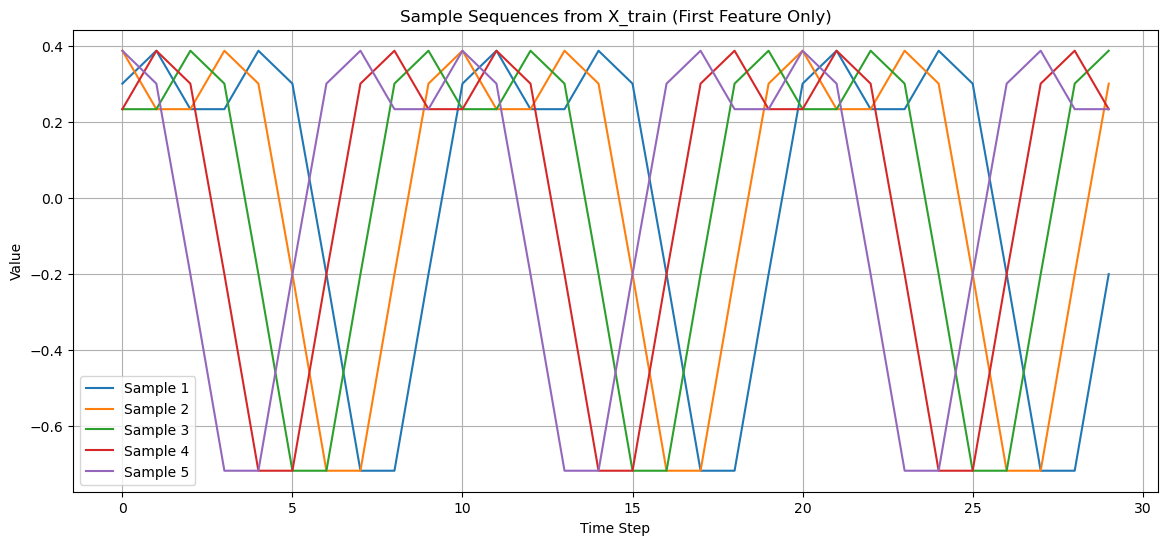

In [84]:

# Parameters and data setup
forecast_steps = 10
input_window_size = 30
num_features = 5
input_dim = 5
num_clusters_list = [16, 8, 1]
num_fuzzy_layers_list = [3, 1, 1]
num_heads = 5  # Number of heads for the MultiHeadFuzzyAttentionLayer

# Create a synthetic multivariate time series dataset
def create_synthetic_multivariate_time_series(timesteps, num_features, frequency=0.1):
    time = np.arange(0, timesteps)
    # Create a time series with a combination of sine and cosine functions for each feature
    time_series = np.zeros((timesteps, num_features), dtype=np.float32)
    for i in range(num_features):
        time_series[:, i] = 0.5 * np.sin(2 * np.pi * frequency * time) + 0.3 * np.cos(4 * np.pi * frequency * time)
    return torch.tensor(time_series, dtype=torch.float32)

# Create forecasting data
def create_forecasting_data(data, input_window_size, forecast_steps):
    """Segment the time series data for forecasting."""
    X = torch.stack([data[i:i+input_window_size] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    y = torch.stack([data[i+input_window_size:i+input_window_size+forecast_steps] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    return X, y

extended_timesteps = 300
extended_synthetic_time_series = create_synthetic_multivariate_time_series(extended_timesteps, num_features, frequency=0.1)
X_train, y_train = create_forecasting_data(extended_synthetic_time_series, input_window_size, forecast_steps)

# Plotting the first feature from a few sample sequences in X_train
plt.figure(figsize=(14, 6))

for i in range(5):
    plt.plot(range(input_window_size), X_train[i, :, 0], label=f"Sample {i+1}")

plt.title("Sample Sequences from X_train (First Feature Only)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()



In [85]:

# DataLoader for training
batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Loss function
loss_function = nn.MSELoss()

# Model and Optimizer
multihead_forecasting_model = MultiHeadForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, input_dim, num_heads)
optimizer = torch.optim.Adam(multihead_forecasting_model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = multihead_forecasting_model(batch_X)
        loss = loss_function(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")


Epoch 1/100, Loss: 0.6951
Epoch 2/100, Loss: 0.4883
Epoch 3/100, Loss: 0.3712
Epoch 4/100, Loss: 0.3011
Epoch 5/100, Loss: 0.2500
Epoch 6/100, Loss: 0.2199
Epoch 7/100, Loss: 0.2189
Epoch 8/100, Loss: 0.2155
Epoch 9/100, Loss: 0.2310
Epoch 10/100, Loss: 0.2249
Epoch 11/100, Loss: 0.2312
Epoch 12/100, Loss: 0.2219
Epoch 13/100, Loss: 0.2124
Epoch 14/100, Loss: 0.2074
Epoch 15/100, Loss: 0.2122
Epoch 16/100, Loss: 0.2063
Epoch 17/100, Loss: 0.2137
Epoch 18/100, Loss: 0.2161
Epoch 19/100, Loss: 0.2098
Epoch 20/100, Loss: 0.2015
Epoch 21/100, Loss: 0.2074
Epoch 22/100, Loss: 0.2087
Epoch 23/100, Loss: 0.2010
Epoch 24/100, Loss: 0.1983
Epoch 25/100, Loss: 0.2051
Epoch 26/100, Loss: 0.2007
Epoch 27/100, Loss: 0.1962
Epoch 28/100, Loss: 0.1959
Epoch 29/100, Loss: 0.1913
Epoch 30/100, Loss: 0.1956
Epoch 31/100, Loss: 0.1903
Epoch 32/100, Loss: 0.1971
Epoch 33/100, Loss: 0.1978
Epoch 34/100, Loss: 0.1971
Epoch 35/100, Loss: 0.1907
Epoch 36/100, Loss: 0.1916
Epoch 37/100, Loss: 0.1844
Epoch 38/1

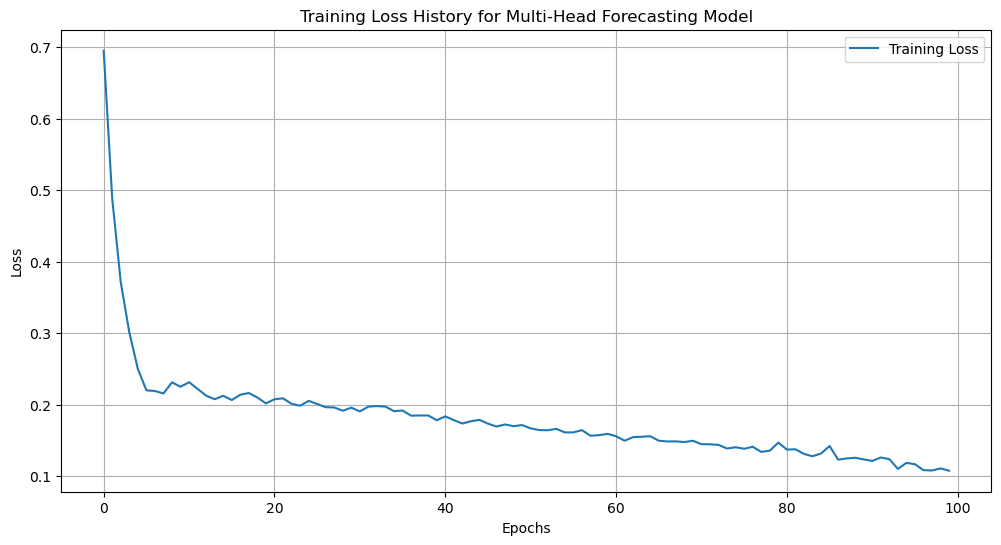

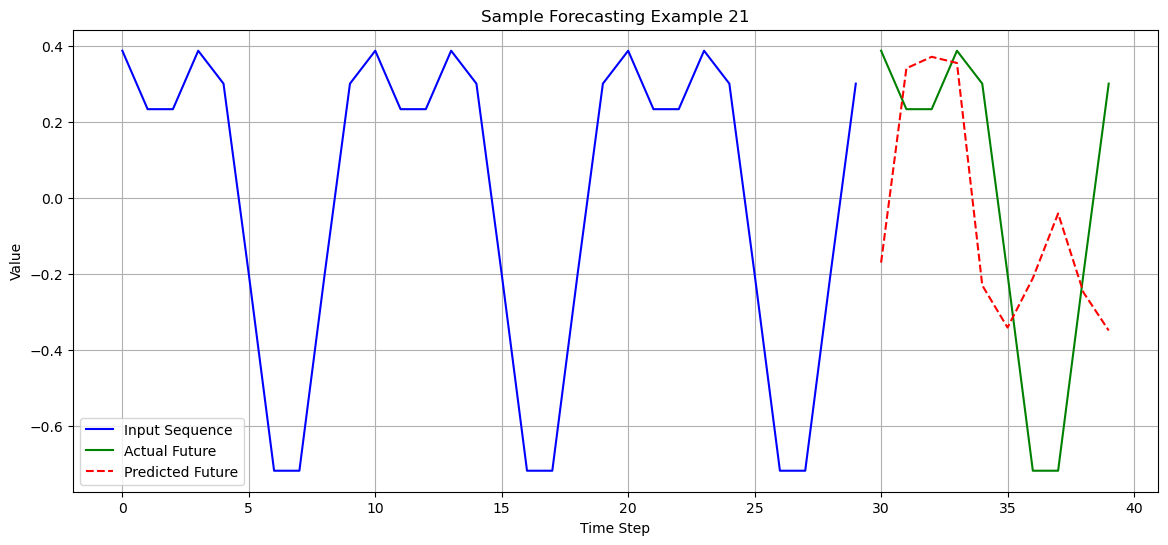

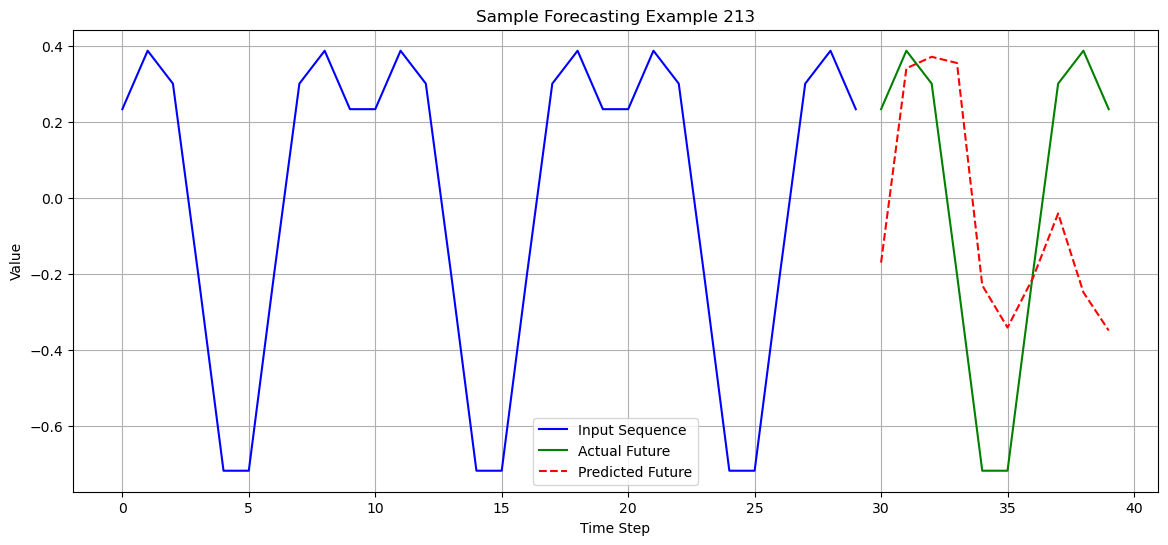

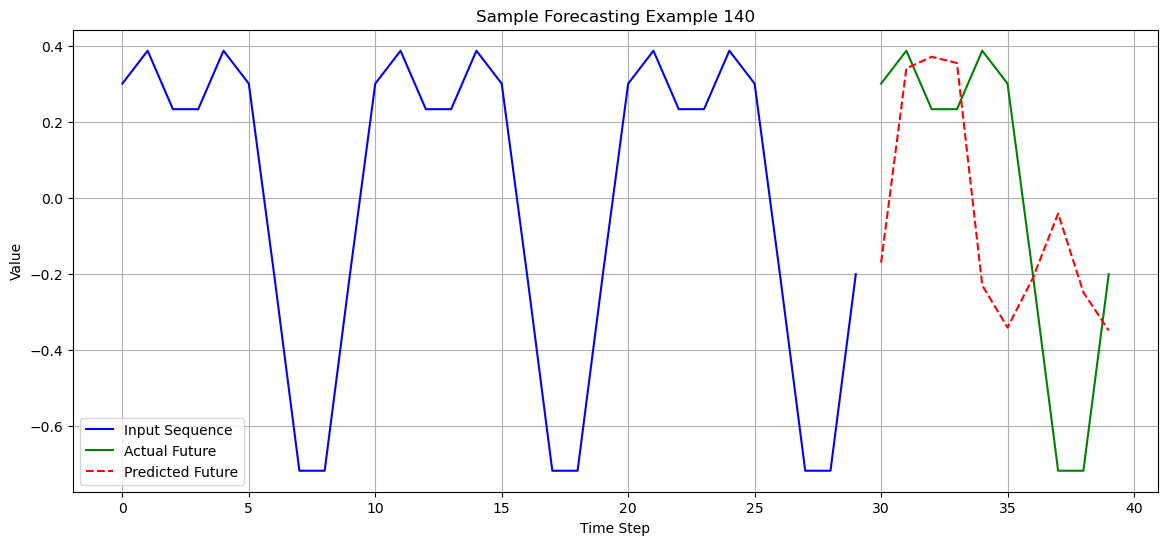

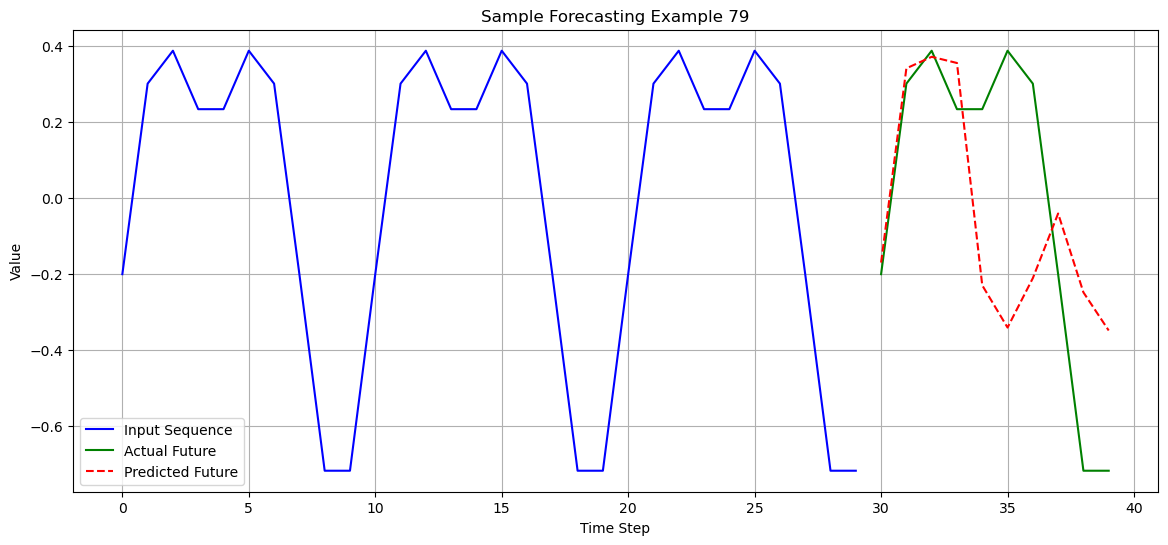

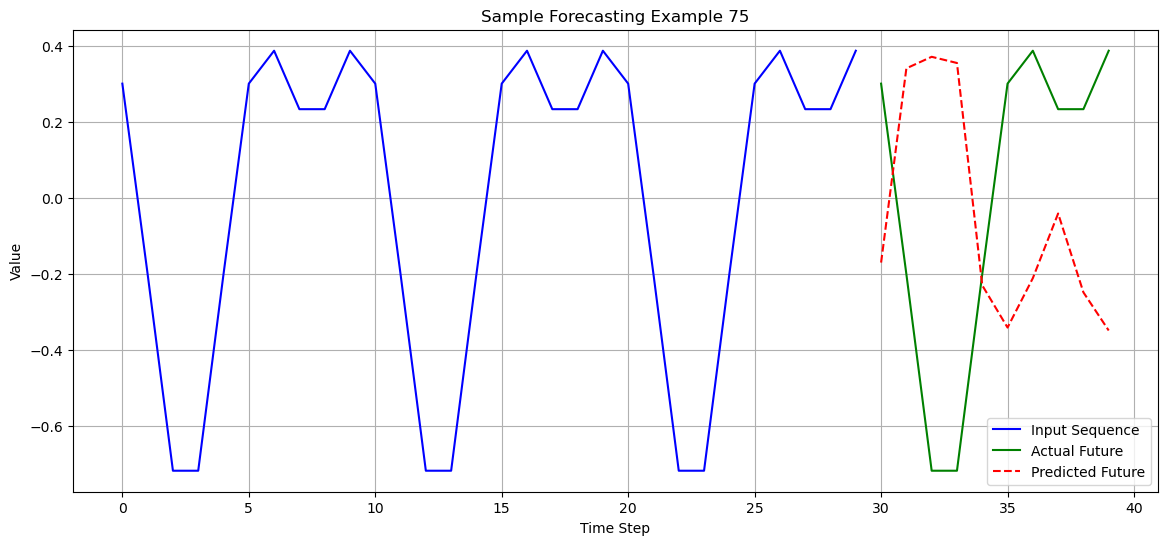

In [89]:
import matplotlib.pyplot as plt

# Plot the training loss for the multi-head forecasting model
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss History for Multi-Head Forecasting Model")
plt.legend()
plt.grid(True)
plt.show()

multihead_forecasting_model.eval()
# Visualization of model's predictions
sample_idx = np.random.choice(len(X_train), 5, replace=False)
for idx in sample_idx:
    sample_input = X_train[idx].unsqueeze(0)
    actual_output = y_train[idx]
    #predicted_output = multihead_forecasting_model(sample_input)
    
    plt.figure(figsize=(14, 6))
    plt.plot(range(input_window_size), sample_input[0, :, 0].detach().cpu(), label="Input Sequence", color="blue")
    plt.plot(range(input_window_size, input_window_size + forecast_steps), actual_output[:, 0].detach().cpu(), label="Actual Future", color="green")
    plt.plot(range(input_window_size, input_window_size + forecast_steps), predicted_output[0, :, 0].detach().cpu(), label="Predicted Future", color="red", linestyle="--")
    plt.title(f"Sample Forecasting Example {idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()